# Hand Gesture Recognition #

Team Members:  
  - Anjan Shrestha 
  - Aashish Pandey 
  - Nitin Dunday Mohan 
  - Asher Pranay

Reference/ Citation: https://github.com/Nkap23/background_removal_DL.git

### Import and Packages ###

In [1]:
# For working with Google Colab and files
from google.colab import drive
from google.colab import files
import os

# Model
from sklearn import tree
from sklearn.model_selection import train_test_split
from skimage.feature import ORB
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from cv2 import cv2 
from PIL import Image

# For downloading files from google drive 
import gdown

# For Background Substitution 
import shutil
import re
import pathlib


In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Dataset Creation ##

### I. Background Substitution / Gesture Enhancement (Feature Enginneeing) ###

In [3]:
# Preparation step to run background substitution project
# Uncomment and run if its a first time run 
'''

# Clone the repo for background substitution project
%cd '/content/gdrive/MyDrive'
!git clone https://github.com/Nkap23/background_removal_DL.git

# Create a new directory named as u2net_results
%cd '/content/gdrive/MyDrive/background_removal_DL/test_data/images'
!mkdir u2net_results

# Download the pretrained u2net model
%cd '/content/gdrive/MyDrive/background_removal_DL/saved_models/u2net'
url = 'https://drive.google.com/u/0/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ'
output = 'u2net.pth'
gdown.download(url, output, quiet=False)

'''

"\n\n# Clone the repo for background substitution project\n%cd '/content/gdrive/MyDrive'\n!git clone https://github.com/Nkap23/background_removal_DL.git\n\n# Create a new directory named as u2net_results\n%cd '/content/gdrive/MyDrive/background_removal_DL/test_data/images'\n!mkdir u2net_results\n\n# Download the pretrained u2net model\n%cd '/content/gdrive/MyDrive/background_removal_DL/saved_models/u2net'\nurl = 'https://drive.google.com/u/0/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ'\noutput = 'u2net.pth'\ngdown.download(url, output, quiet=False)\n\n"

In [4]:
# Image path for original image and background substituted image
base_path = '/content/gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/leapGestRecog'
base_path_bs = '/content/gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/leapGestRecog_bs'

# Get input location for background removal model
input_location = '/content/gdrive/MyDrive/background_removal_DL/test_data/images/input/'
output_location = '/content/gdrive/MyDrive/background_removal_DL/test_data/images/u2net_results/'

In [5]:
# Performing background substitution 
# Uncomment and run if its a first time run 
'''
for subdir, dirs, files in os.walk(base_path):
  for file in files:
      image_path = os.path.join(subdir, file)
      if image_path.endswith('.png'):
        

        # Copy image to input location 
        shutil.copy(image_path, input_location)

        # Run Background Substitution Model
        %cd '/content/gdrive/MyDrive/background_removal_DL'
        !python u2net_image.py  

        # Remove image from input location after running model
        os.remove(input_location + file)

        # Define image path for background substituted images
        image_path_bs = re.sub(base_path, base_path_bs, image_path)

        # Create subdirectories if it does not exist
        image_dir_bs = '/'.join(image_path_bs.split('/')[:-1])
        pathlib.Path(image_dir_bs).mkdir(parents=True, exist_ok=True) 

        # Move image from output location to different location
        shutil.move(output_location + file, image_path_bs)
'''


"\nfor subdir, dirs, files in os.walk(base_path):\n  for file in files:\n      image_path = os.path.join(subdir, file)\n      if image_path.endswith('.png'):\n        \n\n        # Copy image to input location \n        shutil.copy(image_path, input_location)\n\n        # Run Background Substitution Model\n        %cd '/content/gdrive/MyDrive/background_removal_DL'\n        !python u2net_image.py  \n\n        # Remove image from input location after running model\n        os.remove(input_location + file)\n\n        # Define image path for background substituted images\n        image_path_bs = re.sub(base_path, base_path_bs, image_path)\n\n        # Create subdirectories if it does not exist\n        image_dir_bs = '/'.join(image_path_bs.split('/')[:-1])\n        pathlib.Path(image_dir_bs).mkdir(parents=True, exist_ok=True) \n\n        # Move image from output location to different location\n        shutil.move(output_location + file, image_path_bs)\n"

### II. Create Dataset ###

In [6]:
# Creating Data from background substitution 
# Uncomment and run if its a first time run 
'''
X = []
y = []
image_paths= []

# Get all the image paths 
for subdir, dirs, files in os.walk(base_path_bs):
    for file in files:
        image_path = os.path.join(subdir, file)
        if image_path.endswith('.png'):
            image_paths.append(image_path)

# Read background substituted image 
for path in image_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (320, 120))
    X.append(img)
    
    # Processing label in image path
    category = path.split("/")[8]
    label = int(category.split("_")[0][1])
    y.append(label)
    
# Convert it to numpy array
X = np.array(X, dtype="uint8")
y = np.array(y)

# Store the X and y array to .npy file for faster loading
np.save('gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/X_full.npy', X)
np.save('gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/y_full.npy', y)

'''

'\nX = []\ny = []\nimage_paths= []\n\n# Get all the image paths \nfor subdir, dirs, files in os.walk(base_path_bs):\n    for file in files:\n        image_path = os.path.join(subdir, file)\n        if image_path.endswith(\'.png\'):\n            image_paths.append(image_path)\n\n# Read background substituted image \nfor path in image_paths:\n    img = cv2.imread(path)\n    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n    img = cv2.resize(img, (320, 120))\n    X.append(img)\n    \n    # Processing label in image path\n    category = path.split("/")[8]\n    label = int(category.split("_")[0][1])\n    y.append(label)\n    \n# Convert it to numpy array\nX = np.array(X, dtype="uint8")\ny = np.array(y)\n\n# Store the X and y array to .npy file for faster loading\nnp.save(\'gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/X_full.npy\', X)\nnp.save(\'gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/y_full.npy\', y)\n\n'

In [7]:
# Loading X and y array from .npy file that has been stored before for faster loading
X = np.load('gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/X_full.npy')
y = np.load('gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/y_full.npy')

In [8]:
# Create Dict of label
label_dict = {
    1 : 'PALM',
    2 : 'L-SHAPE',
    3 : 'FIST',
    4 : 'FIST-MOVED',
    5 : 'THUMB',
    6 : 'INDEX',
    7 : 'OK',
    8 : 'PALM-MOVED',
    9 : 'C-SHAPE',
    0: 'DOWN'
}

In [9]:
print(X.shape)
print(y.shape)

(2000, 120, 320)
(2000,)


## 2. Exploratory Data Analysis ##

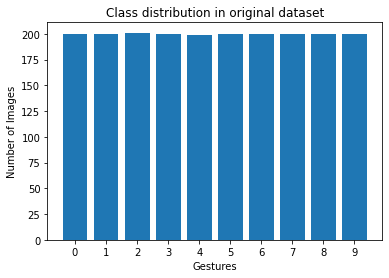

In [10]:
# Class Distribution for Original Dataset (Barplot)
(unique, counts) = np.unique(y, return_counts=True)

f, ax = plt.subplots()
plt.bar(unique, counts)
plt.title("Class distribution in original dataset")
plt.xlabel("Gestures")
plt.ylabel("Number of Images")
ax.set_xticks(unique)
ax.set_xticklabels(range(10))

plt.show()

## 3. Feature Engineering ##

### I. Image Sharpening ###

In [11]:
# Function to create gaussian mask
def create_gaussian_mask(x, y, sigma=1):
    return np.exp(-((x**2 + y**2)/(2*sigma**2)))

# Function to apply Gaussian Filters 
def apply_gaussian_filter(mask_size, sigma=1):
    i = -mask_size//2 + 1
    j = mask_size//2 + 1
    x,y = np.mgrid[i:j, i:j]
    gaussain_mask = create_gaussian_mask(x,y,sigma)
    return gaussain_mask/gaussain_mask.sum()

def sharpen_image(img):
  # Smoothing 
  k3_3 = apply_gaussian_filter(3,1)
  smoothen_img = cv2.filter2D(img,-1,k3_3, borderType=cv2.BORDER_CONSTANT)  

  # Sharpening
  return np.subtract(img, smoothen_img) 


### II. Edge Detection ###

In [12]:
def apply_hor_filter(img):
  # Horizontal Edge detection Kernal - Purpose is to detect horizontal edge in the image
  hor_filter = np.array([[ 1, 1, 1],                        
                    [ 0, 0, 0],
                    [ -1, -1, -1]])
  return cv2.filter2D(img,-1,hor_filter, borderType=cv2.BORDER_CONSTANT)   

def apply_ver_filter(img):
  # Vertical Edge detection Kernal - Purpose is to detect vertical edge in the image
  ver_filter = np.array([[ 1, 0, -1],                        
                    [ 1, 0, -1],
                    [ 1, 0, -1]])
  return cv2.filter2D(img,-1,ver_filter, borderType=cv2.BORDER_CONSTANT)   

### III. Harris Corner Detection ###

In [13]:
def apply_harris_corner_detection(img):
  gray = np.float32(img)
  return cv2.cornerHarris(gray,2,3,0.04)

### V. Generate Features ###

In [14]:
# 1. Image Sharpening
sharpen_imgs = [ sharpen_image(img) for img in X]

# 2.a Vertical Edges
vertical_edges = [ apply_ver_filter(sharpen_img) for sharpen_img in sharpen_imgs]

# 2.b Horizontal Edges
horizontal_edges = [ apply_hor_filter(sharpen_img) for sharpen_img in sharpen_imgs]

# 3. Harris Corner Detection
harris_corners = [ apply_harris_corner_detection(sharpen_img) for sharpen_img in sharpen_imgs]


In [15]:
# Integrating all the features 
X_final = []
for row_index in range(len(X)):
    X_final.append(np.hstack((np.array(vertical_edges[row_index]).flatten(), np.array(horizontal_edges[row_index]).flatten(), np.array(harris_corners[row_index]).flatten())))

## 4. Split Dataset into train and test ##

In [16]:
# Change this before submitting - only for development
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=200)

## 5. Create and Train model ##

In [17]:
# Creating Decision Tree model
d_tree = tree.DecisionTreeClassifier()

# Training the model
clf = d_tree.fit(X_train, y_train)

## 6. Evaluate Model ##

In [18]:
# Making prediction for testing data
y_pred = clf.predict(X_test)

In [19]:
# Calculating accuracy score
metrics.accuracy_score(y_test, y_pred)

0.86

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


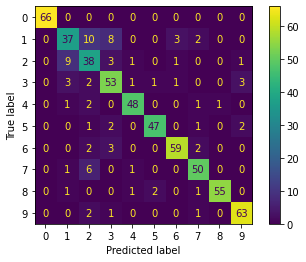

In [20]:
# Plotting Confusion Matrix
plot_confusion_matrix(clf, X_test, y_test) 
plt.show()

## 7. Predict Gesture ##

In [35]:
# Base path where image that needs to be predicted is stored
base_path_prediction = '/content/gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/prediction/'

# Function that predict the gesture
def predict_gesture(image_path):

  # Original Image
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (320, 120))
  
  # 1. Background Substitution
  shutil.copy(image_path, input_location)

  # Run Background Substitution Model
  %cd '/content/gdrive/MyDrive/background_removal_DL'
  !python u2net_image.py  

  # Remove image from input location after running model
  file_name = image_path.split('/')[-1]
  os.remove(input_location + file_name)

  # Move image from output location to different location
  image_path_bs = base_path_prediction + 'bs_' + file_name
  shutil.move(output_location + file_name, image_path_bs)

  # 2. Read Background Substituted Image
  img_bs = cv2.imread(image_path_bs, cv2.IMREAD_GRAYSCALE)
  img_bs = cv2.resize(img_bs, (320, 120))

  # 3. Image Sharpening
  p_sharped_img = sharpen_image(img_bs)

  # 4.a. Vertical Edges
  p_vertical_edge = apply_ver_filter(p_sharped_img)

  # 5.b. Horizontal Edges
  p_horizontal_edge = apply_hor_filter(p_sharped_img)

  # 6. Harris Corner Detection
  p_harris_corner = apply_harris_corner_detection(p_sharped_img)

  # 7. Integrate Features
  img_features = np.hstack((np.array(p_vertical_edge).flatten(), np.array(p_horizontal_edge).flatten(), np.array(p_harris_corner).flatten()))

  # 8. Make Prediction
  gesture = clf.predict([img_features])[0]

  # 9. Plotting
  fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(15, 6), constrained_layout=True)
  ax1.imshow(img, 'gray')
  ax1.set_title('Original Image')
  ax2.imshow(img_bs, 'gray')
  ax2.set_title('After Background Sustitution on Original Image')
  ax3.imshow(p_sharped_img, 'gray')
  ax3.set_title('After Image Sharpening on Background Substituted Image')
  ax4.imshow(p_vertical_edge, 'gray')
  ax4.set_title('After Vertical Edge Detection on Sharp Image')
  ax5.imshow(p_horizontal_edge, 'gray')
  ax5.set_title('After Horizontal Edge Detection on Sharp Image')
  ax6.imshow(p_harris_corner, 'gray')
  ax6.set_title('After Harris Corner Detection on Sharp Image')

  return label_dict[gesture]


### Gesture Prediction 1 ###

/content/gdrive/MyDrive/background_removal_DL
['/content/gdrive/MyDrive/background_removal_DL/test_data/images/input/fist.png']
...load U2NET---173.6 MB
inferencing: fist.png
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigm

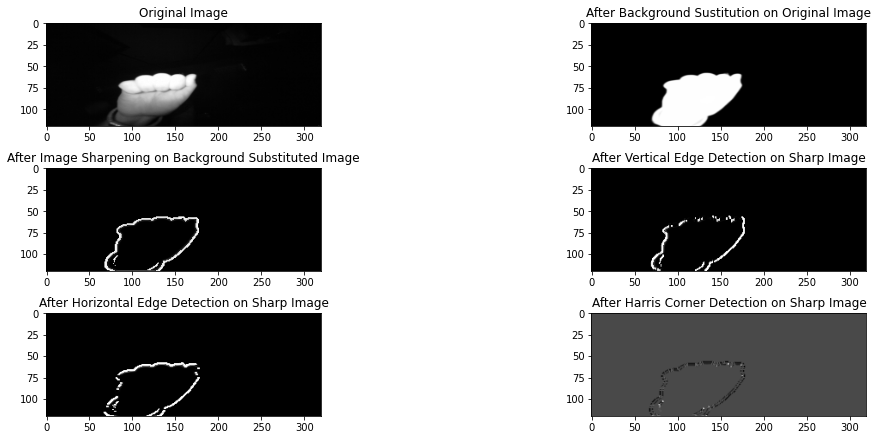

In [36]:
# Make Gesture Prediction
gesture = predict_gesture('/content/gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/prediction/fist.png')

In [37]:
print('The predicted gesture is: ', gesture)

The predicted gesture is:  FIST


### Gesture Prediction 2 ###

/content/gdrive/MyDrive/background_removal_DL
['/content/gdrive/MyDrive/background_removal_DL/test_data/images/input/down.png']
...load U2NET---173.6 MB
inferencing: down.png
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigm

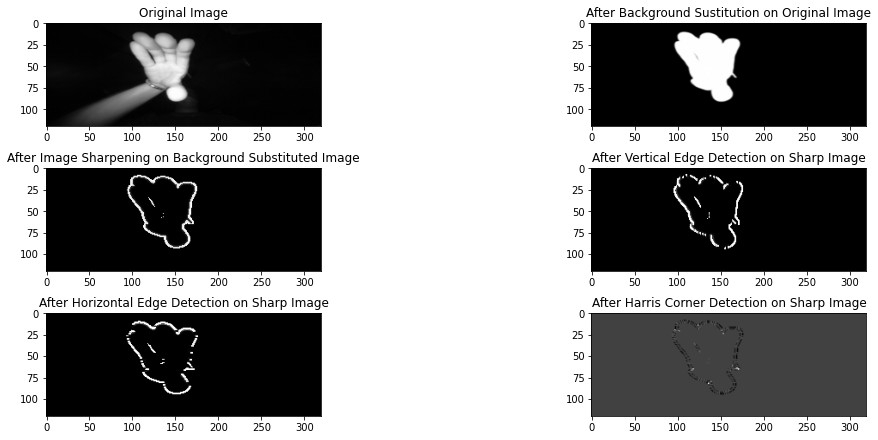

In [24]:
# Make Gesture Prediction
gesture = predict_gesture('/content/gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/prediction/down.png')

In [25]:
print('The predicted gesture is: ', gesture)

The predicted gesture is:  DOWN


### Gesture Prediction 3 ###

/content/gdrive/MyDrive/background_removal_DL
['/content/gdrive/My Drive/background_removal_DL/test_data/images/input/thumb.png']
...load U2NET---173.6 MB
inferencing: thumb.png
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.s

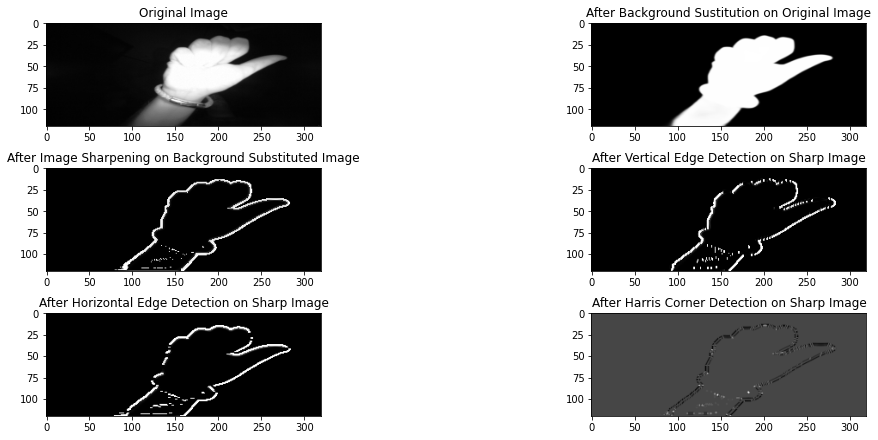

In [26]:
# Make Gesture Prediction
gesture = predict_gesture('/content/gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/prediction/thumb.png')

In [27]:
print('The predicted gesture is: ', gesture)

The predicted gesture is:  THUMB
